# Deconvolution algorithm performance

In [1]:
import matplotlib
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from IPython.display import Image
from IPython.core.display import HTML 
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import Core.system_of_units as units
import tables
import Core.mplFunctions as mpl
import Core.wfmFunctions as wfm

In [3]:
import Sierpe.FEE as FE

In [4]:
import time

In [5]:
import pandas as pd

In [6]:
from Core.coreFunctions import wait

In [7]:
from Database import loadDB

In [8]:
import Database.loadDB as DB

In [9]:
import ICython.cBLR as cblr

In [28]:
%load_ext Cython

## Revised on:

In [10]:
print(time.strftime("%d/%m/%Y"))

19/11/2016


In [11]:
print(time.strftime("%H:%M:%S"))

11:21:59


###  Code exercized

In [12]:
!/Users/jjgomezcadenas/anaconda2/bin/pep8 ../../Sierpe/FEE.py

In [13]:
!/Users/jjgomezcadenas/anaconda2/bin/pyflakes ../../Sierpe/FEE.py

In [14]:
DataPMT = loadDB.DataPMT()

In [15]:
DataPMT

,channel,pmtid,active,x,y,coeff_c,coeff_blr,adc_to_pes,noise_rms
0,0,1,1,-23.941401,65.778503,0.000003,0.001632,-22.9168,0.7060
1,18,3,1,-44.995098,-53.623100,0.000003,0.001632,-23.7510,0.8744
2,1,2,1,68.936501,-12.155400,0.000003,0.001611,-25.3008,0.7213
3,19,4,1,0.000000,185.000000,0.000003,0.001599,-25.9984,0.7624
4,27,C,1,-118.916000,141.718002,0.000003,0.001567,-23.7074,0.7921
5,26,B,1,-182.188995,32.124901,0.000004,0.001650,-20.8927,0.8660
6,9,A,1,-160.214996,-92.500000,0.000003,0.001593,-22.1340,0.7062
7,8,9,1,-63.273701,-173.843002,0.000003,0.001612,-33.0993,0.7278
8,23,8,1,63.273701,-173.843002,0.000003,0.001601,-20.4377,0.7303
9,22,7,1,160.214996,-92.500000,0.000003,0.001593,-25.1698,0.7160


### Monte Carlo data

1. Running on electrons of fixed energy (40, 1250, 2500 keV)  in the center of chamber.
2. Nominal yield factor in current NEW conditions (7 bar, 7 kV in gate) is 574 photons/e
3. Monte Carlo yield factor 690 photons/e
4. Running of Kripton, Na, Tl, with yield factor 574 photons/e

In [16]:
yield_factor = 574./690.
print('Yield factor (MC to NEW running conditions, November, 2016 = {})'.format(yield_factor))

Yield factor (MC to NEW running conditions, November, 2016 = 0.831884057971)


#### List the files

In [17]:
ls /Users/jjgomezcadenas/Documents/Development/NEXT/icdata

CalibElectrons/ CalibMC/        IC/             LSC/


In [18]:
pathmc='/Users/jjgomezcadenas/Documents/Development/NEXT/icdata/CalibMC/'
pathel='/Users/jjgomezcadenas/Documents/Development/NEXT/icdata/CalibElectrons/'
pathlsc='/Users/jjgomezcadenas/Documents/Development/NEXT/icdata/LSC/'

In [19]:
ls '/Users/jjgomezcadenas/Documents/Development/NEXT/icdata/CalibMC/'

dst_NEXT_HEAD_Kr_ACTIVE_0_0_7bar_MCRD_10000.root.h5*
dst_NEXT_HEAD_Na_INTERNALPORTANODE_0_0_7bar_MCRD_10000.root.h5*
dst_NEXT_HEAD_Tl_INTERNALPORTANODE_0_0_7bar_MCRD_10000.root.h5*


In [20]:
ls '/Users/jjgomezcadenas/Documents/Development/NEXT/icdata/CalibElectrons/'

electrons.1250.0keV.z250mm.next_1000.root.h5
electrons.2500.0keV.z250mm.next_1000.root.h5
electrons.40.0keV.z250mm.next_1000.root.h5


#### Kripton Na-22 and Th at 7bar 

In [22]:
kr7bar = tables.open_file(pathmc+'dst_NEXT_HEAD_Kr_ACTIVE_0_0_7bar_MCRD_10000.root.h5','r+')

In [23]:
na7bar = tables.open_file(pathmc+'dst_NEXT_HEAD_Na_INTERNALPORTANODE_0_0_7bar_MCRD_10000.root.h5','r+')

In [24]:
Tl7bar = tables.open_file(pathmc+'dst_NEXT_HEAD_Tl_INTERNALPORTANODE_0_0_7bar_MCRD_10000.root.h5','r+')

#### Electrons of fixed energy

In [25]:
e2500 = tables.open_file(pathel+'electrons.1250.0keV.z250mm.next_1000.root.h5','r+')

In [26]:
e1250 = tables.open_file(pathel+'electrons.1250.0keV.z250mm.next_1000.root.h5','r+')

In [27]:
e40 = tables.open_file(pathel+'electrons.40.0keV.z250mm.next_1000.root.h5','r+')

## SIMULATING THE EFFECT OF ELECTRONICS OVER MC DATA

### PROCEDURE

1. Read MCRD (bins of 1 ns).
2. Convolute with SPE response to form a signal_i (units of A)
3. Decimate the signal.
4. Simulate the effect of the filter.

In [93]:
def simulate_pmt_response(pmtrd, event=0):
    """
    Input:
     1) extensible array pmtrd
     2) event_number

    returns:
    array of raw waveforms (RWF), obtained by convoluting pmtrd_ with the PMT
    front end electronics (LPF, HPF)
    array of BLR waveforms (only decimation)
    """

    spe = FE.SPE()  # spe
    # FEE, with noise PMT
    fee = FE.FEE(noise_FEEPMB_rms=FE.NOISE_I, noise_DAQ_rms=FE.NOISE_DAQ)
    NPMT = pmtrd.shape[1]
    RWF = []
    BLRX = []
    DataPMT = DB.DataPMT()
    adc_to_pes = np.abs(DataPMT.adc_to_pes.values)
    for pmt in range(NPMT):
        # signal_i in current units
        cc = adc_to_pes[pmt] / FE.ADC_TO_PES
        signal_i = FE.spe_pulse_from_vector(spe, pmtrd[event, pmt])
        # Decimate (DAQ decimation)
        signal_d = FE.daq_decimator(FE.f_mc, FE.f_sample, signal_i)
        # Effect of FEE and transform to adc counts
        signal_fee = FE.signal_v_fee(fee, signal_d, pmt) * FE.v_to_adc()
        # add noise daq
        signal_daq = cc * FE.noise_adc(fee, signal_fee)
        # signal blr is just pure MC decimated by adc in adc counts
        signal_blr = cc * FE.signal_v_lpf(fee, signal_d)*FE.v_to_adc()
        # raw waveform stored with negative sign and offset
        RWF.append(FE.OFFSET - signal_daq)
        # blr waveform stored with positive sign and no offset
        BLRX.append(FE.OFFSET - signal_blr)
    return np.array(RWF), np.array(BLRX)


In [115]:
cf = [7./c for c in DataPMT.coeff_blr]

In [116]:
cf

[4288.1357697295598,
 4288.1357697295598,
 4344.8467634615772,
 4376.7616465627416,
 4467.2543871628977,
 4243.4066553589983,
 4394.3267985508764,
 4342.2485900098509,
 4373.1332187572425,
 4395.0027562945861,
 4443.902711542466,
 4385.0802031169151]

In [127]:
def deconv_cpmt(RWF, coeff_c, coeff_blr, thr_trigger=5):
    """
    Deconvolution of all the PMTs in the event cython function
    """
    NPMT = len(RWF)
    CWF = []
    ACUM = []
    for pmt in range(NPMT):
        acum_thr = thr_trigger/coeff_blr[pmt]
        signal_r, acum = cblr.deconvolve_signal_acum(RWF[pmt].astype(np.int16), n_baseline=500, 
                                 coef_clean=coeff_c[pmt], 
                                 coef_blr=coeff_blr[pmt], 
                                 thr_trigger=thr_trigger, thr_acum=acum_thr, 
                                 acum_discharge_length = 5000, 
                                 acum_tau=2500, 
                                 acum_compress=0.01)
        CWF.append(signal_r)
        ACUM.append(acum)
    return np.array(CWF), np.array(ACUM)

#### Electrons of 40 keV

In [94]:
RWF, BLRX = simulate_pmt_response(e40.root.pmtrd, event=0) 

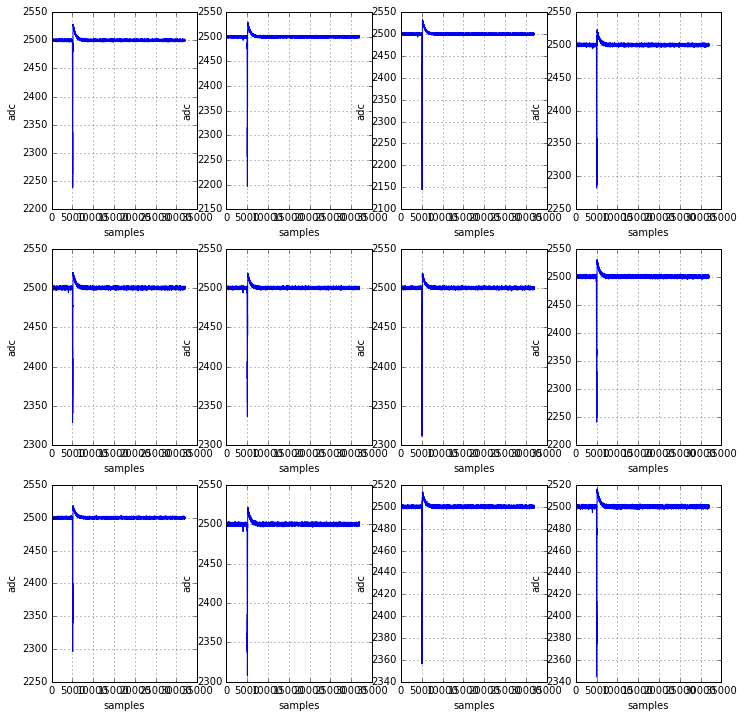

In [95]:
mpl.plot_waveforms(RWF, maxlen=0, zoom=False, window_size=800)

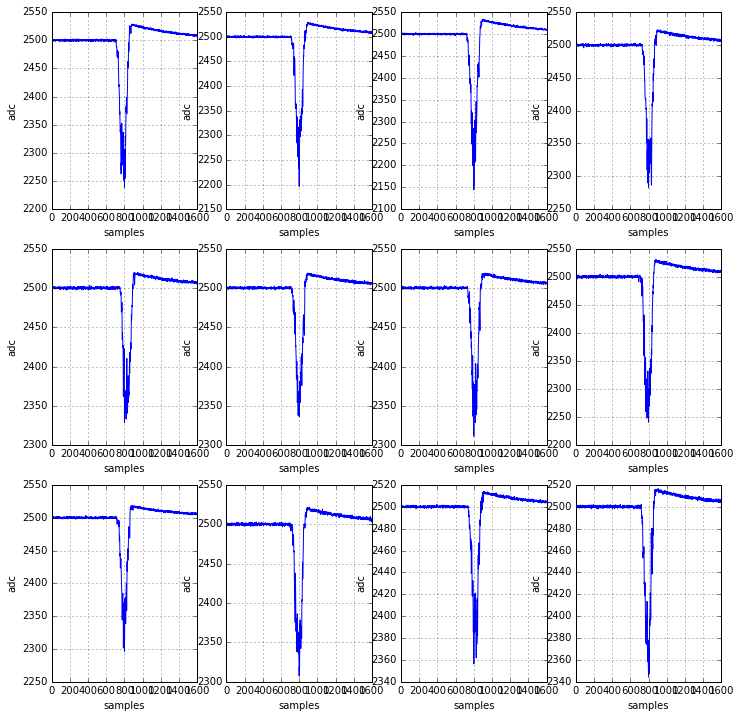

In [96]:
mpl.plot_waveforms(RWF, maxlen=0, zoom=True, window_size=800)

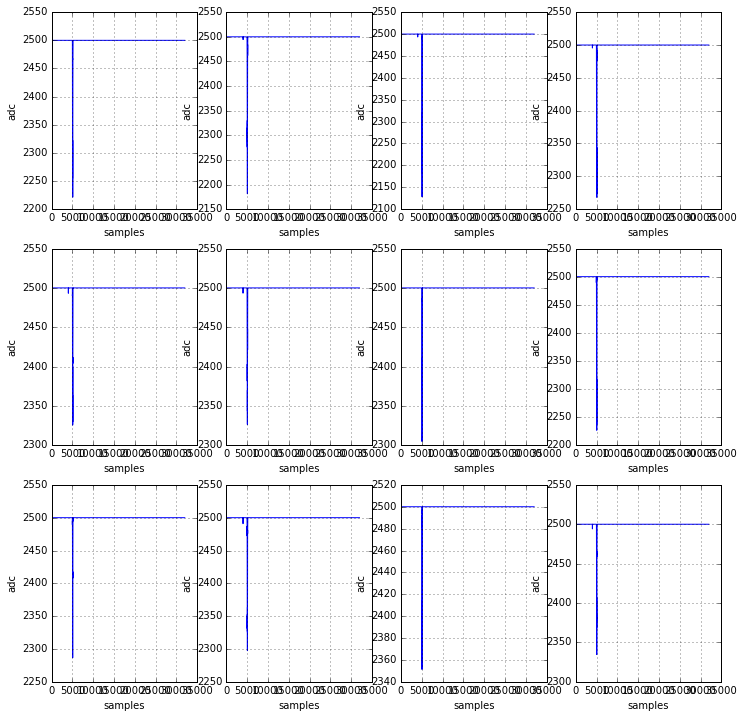

In [97]:
mpl.plot_waveforms(BLRX, maxlen=0, zoom=False, window_size=800)

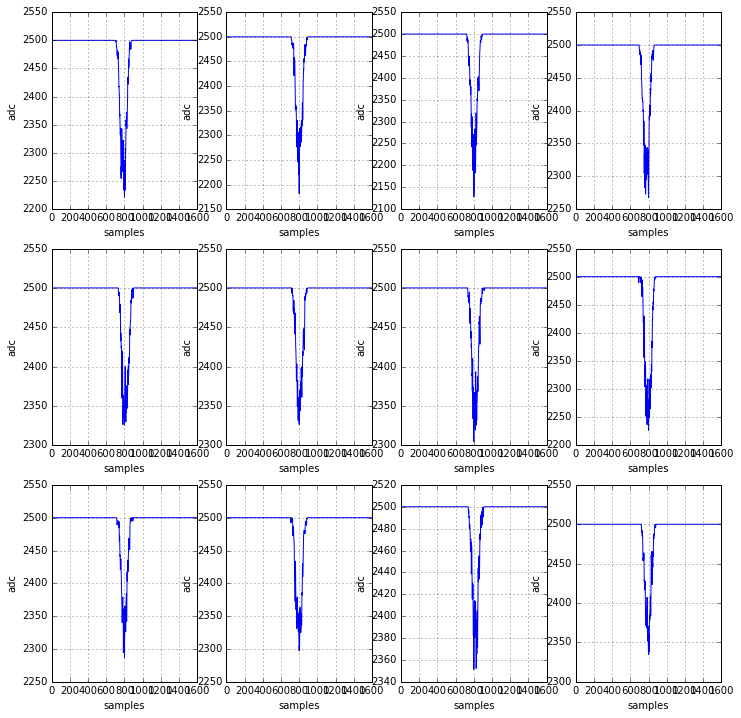

In [98]:
mpl.plot_waveforms(BLRX, maxlen=0, zoom=True, window_size=800)

In [99]:
BLRC = [2500 - blrx for blrx in BLRX]

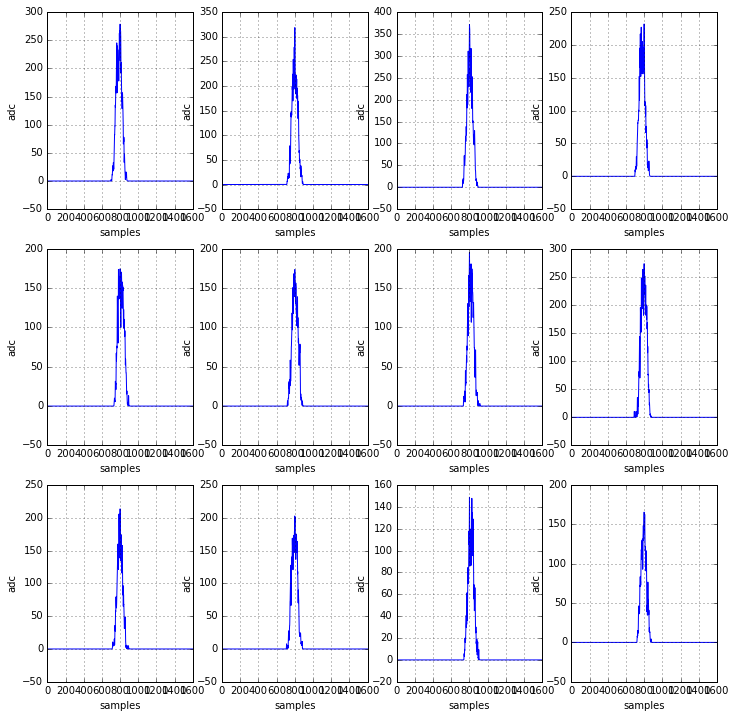

In [100]:
mpl.plot_waveforms(BLRC, maxlen=0, zoom=True, window_size=800)

In [128]:
CWF, ACUM = deconv_cpmt(RWF,DataPMT.coeff_c, DataPMT.coeff_blr, thr_trigger=5)

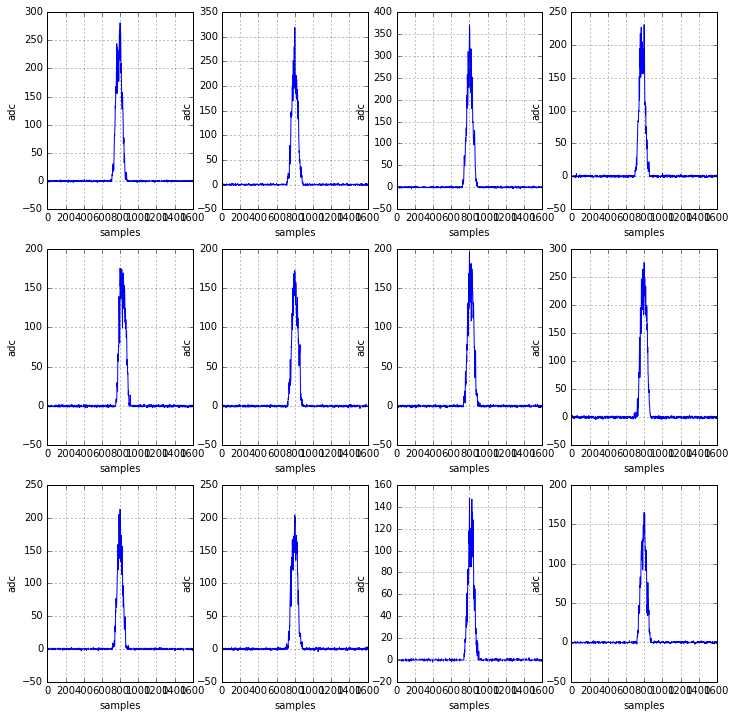

In [129]:
mpl.plot_waveforms(CWF, maxlen=0, zoom=True, window_size=800)

In [158]:
def compare_cwf_blrc(CWF, BLRC, window_size=800):
    """
    Compare PMT CWF and RWF (or BLR). Option zoom takes a window
    around the peak of size *window_size*.
    """
    
    plt.figure(figsize=(12, 12))
    for i, (raw, blr) in enumerate(zip(CWF, BLRC)):
        first, last = mpl.define_window(raw, window_size)
        plt.subplot(3, 4, i+1)
        plt.plot(raw[first:last],'r', label='CWF')
        plt.plot(blr[first:last],'b--', label='BLR')
        legend = plt.legend(loc='upper right')

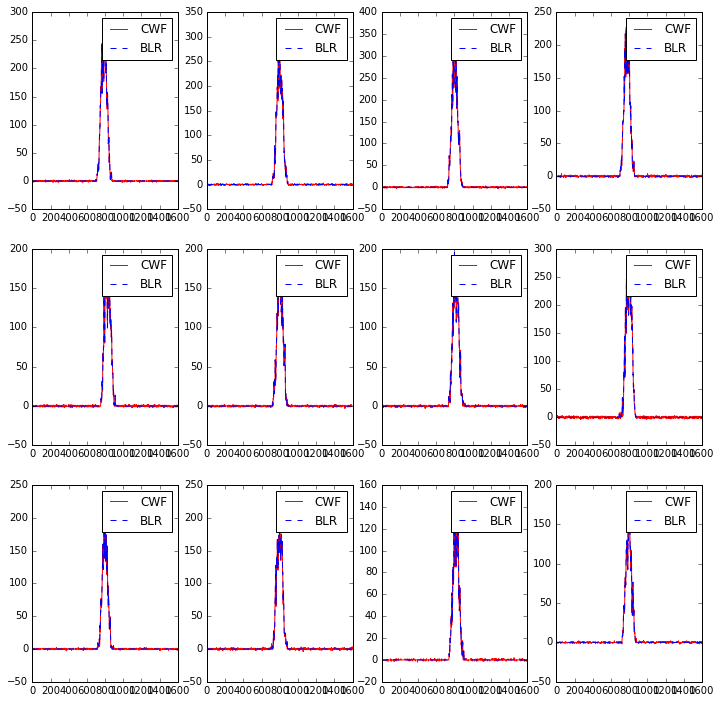

In [159]:
compare_cwf_blrc(CWF, BLRC, window_size=800)

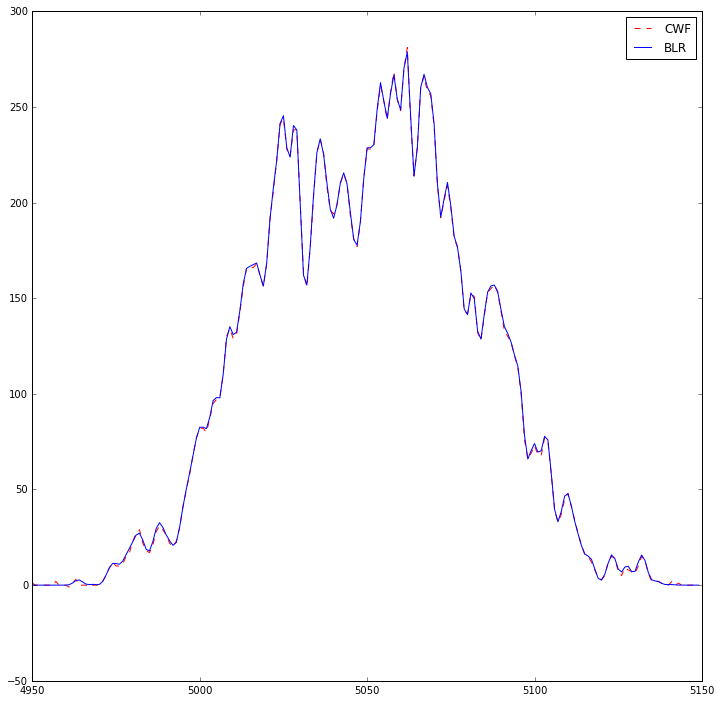

In [162]:
xmin=4950
xmax=5150
plt.figure(figsize=(12, 12))
plt.plot(range(xmin,xmax),CWF[0][xmin:xmax],'r--', label='CWF')
plt.plot(range(xmin,xmax),BLRC[0][xmin:xmax],'b', label='BLR')
plt.legend(loc='upper right')

#### True energy in pes (electrons of 40 keV nominal gain ¡)

In [101]:
e40DF = wfm.get_energy(e40.root.pmtrd, event_list=[0])

In [102]:
e40DF

,0,1,2,3,4,5,6,7,8,9,10,11
0,1217.0,1196.0,1298.0,879.0,823.0,854.0,834.0,865.0,866.0,820.0,871.0,878.0


In [103]:
e40DF.values.flatten()

array([ 1217.,  1196.,  1298.,   879.,   823.,   854.,   834.,   865.,
         866.,   820.,   871.,   878.])

#### Energy in PES of CWF/BLR

In [145]:
def get_energy_WF(WF, adc_to_pes):
    """
    Compute the sum of the waveforms for some events.
    """
    EPMT = [np.sum(wfm)*1./abs(cc) for (wfm, cc) in zip(WF, adc_to_pes)]
    return np.array(EPMT)


In [146]:
eblr = get_energy_WF(BLRC, DataPMT.adc_to_pes)

In [147]:
eblr

array([ 870.6193127 ,  837.08301458,  917.78924845,  611.00039684,
        575.09716079,  604.01951083,  593.36642714,  608.35879236,
        611.33294569,  578.89617246,  606.16125157,  612.10494804])

In [163]:
def cwf_to_cblr_energy_ratio(CWF, CBLR, xmin, xmax):
    """
    Compute the sum of the waveforms for some events.
    """
    EPMT = [np.sum(cwf[xmin:xmax])*1./np.sum(cblr[xmin:xmax])*1. for (cwf, cblr) in zip(CWF, CBLR)]
    return np.array(EPMT)

In [164]:
er = cwf_to_cblr_energy_ratio(CWF, BLRC, xmin=4950, xmax=5150)

In [165]:
er

array([ 0.99529852,  0.994525  ,  0.99542013,  0.99452747,  0.99492744,
        0.99340698,  0.99449709,  0.99335837,  0.98967894,  0.99328599,
        0.988754  ,  0.9955139 ])